In [1]:
import torch
import torch.nn.functional as F

In [2]:
from PIL import Image
import clip
from torchvision import transforms
import numpy as np
import os
from lime.lime_text import LimeTextExplainer

In [3]:
import numpy

In [22]:

# --- Configuration ---
# 1. UPDATE THIS to your local image file.

# --- Configuration ---
# UPDATE THIS PATH to your local image file.
# Example for Windows: 'C:\\Users\\YourUser\\Pictures\\my_image.jpg'
# Example for Mac/Linux: '/home/user/pictures/my_image.jpg'
IMAGE_PATH = 'data\\Mountain_Castle (1).png'
# Frankfurt_Images = [
#     'data\\Frankfurt1.jpg',
#     'data\\Frankfurt2.jpg',
#     'data\\Frankfurt3.jpg',
#     'data\\SK-A-3262.jpg',
# ]

# Marburg_Images = [
#     'data\\Marburg1.jpg',
#     'data\\Marburg2.jpg',
#     'data\\Marburg3.jpg',
#     'data\\SK-A-3263.jpg',
# ]

# The text query you want to explain.
TEXT_QUERY = "CAstle in the mountains"

In [ ]:

# --- Model Paths (should not need to be changed) ---
CLIP_IMAGE_MODEL_PATH = 'models_cpu\\models\\clip_image\\clip_image.pt'
CLIP_TEXT_MODEL_PATH = 'models_cpu\\models\\clip_text\\clip_text.pt'

# Check if CUDA is available and set the device.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
print()

Using device: cpu



In [23]:
# --- Main Execution ---
image_model = torch.jit.load(CLIP_IMAGE_MODEL_PATH, map_location=DEVICE).eval()
text_model = torch.jit.load(CLIP_TEXT_MODEL_PATH, map_location=DEVICE).eval()
# Load the CLIP preprocessing pipeline
clip_preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

# Validate image path
# if not os.path.exists(IMAGE_PATH):
#     print(f"Error: Image not found at '{IMAGE_PATH}'. Please update the IMAGE_PATH variable.")
#     exit()

# Preprocess the image and get its features
print(f"Processing image: {IMAGE_PATH}")
image = Image.open(IMAGE_PATH).convert("RGB")
image_input = clip_preprocess(image).unsqueeze(0).to(DEVICE)
# with torch.no_grad():
#     image_features = image_model(image_input)
#     image_features = F.normalize(image_features, p=2, dim=-1)
# In the "Preprocess the image" section
# with torch.no_grad():
#     # --- Potential Fix if you get a shape-related error ---
#     image_3d = image_input.squeeze(0)
#     image_permuted = image_3d.permute(1, 2, 0)
#     image_features = image_model(image_permuted).unsqueeze(0)
#     # --- End of Fix ---

#     # Original (and standard) code:
#     # image_features = image_model(image_input)

#     image_features = F.normalize(image_features, p=2, dim=-1)

with torch.no_grad():
    # 1. Squeeze the batch dimension to make the input 3D -> [3, 224, 224]
    image_3d_input = image_input.squeeze(0)

    # 2. Permute dimensions from (C, H, W) to (H, W, C) -> [224, 224, 3]
    image_permuted_input = image_3d_input.permute(1, 2, 0)
    
    # 3. Pass the correctly shaped tensor to the model
    image_features = image_model(image_permuted_input)
    
    # 4. Add the batch dimension back for the rest of the script -> [1, 512]
    if image_features.dim() == 1:
        image_features = image_features.unsqueeze(0)
    
    # 5. Normalize the features
    image_features = F.normalize(image_features, p=2, dim=-1)

Processing image: data\Mountain_Castle (1).png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5119728..1.2296118].


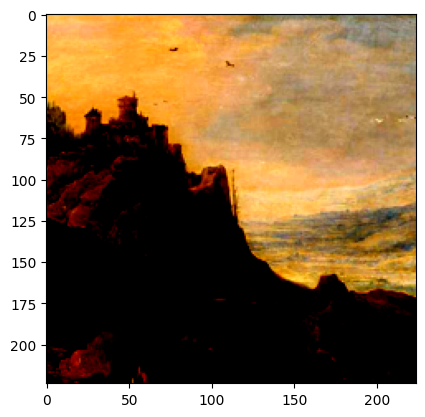

In [24]:
import matplotlib.pyplot as plt
plt.imshow(clip_preprocess(image).permute(1, 2, 0).cpu().numpy())
# plt.title("Original Image")
# plt.axis('off')
plt.show()

In [25]:

# Define the prediction function for LIME
def create_prediction_function(image_features, text_model):
    def prediction_fn(text_samples):
        # The CLIP tokenizer is essential here
        tokenized_text = clip.tokenize(text_samples).to(DEVICE)
        with torch.no_grad():
            text_features = text_model(tokenized_text)
        text_features = F.normalize(text_features, p=2, dim=-1)
        # Calculate similarity
        similarity = (text_features @ image_features.T).squeeze(1)
        # LIME needs a (num_samples, num_classes) array
        return torch.stack([1 - similarity, similarity], dim=-1).cpu().numpy()
    return prediction_fn

# Create LIME explainer
explainer = LimeTextExplainer(class_names=['not similar', 'similar'])
predict_fn = create_prediction_function(image_features, text_model)

In [ ]:
# import clip
# print(clip.__file__)
# print(hasattr(clip, "tokenize"))

c:\Users\PINDA\anaconda3\envs\XAI_iART\lib\site-packages\clip\__init__.py
True


In [26]:
# Run and print the explanation
print(f"\nExplaining the text query: '{TEXT_QUERY}'")
explanation = explainer.explain_instance(
    TEXT_QUERY,
    predict_fn,
    num_features=10,
    labels=(1,)  # Explain the "similar" class
)

print("\n--- LIME Explanation (Word Importance) ---")
for word, score in explanation.as_list(label=1):
    print(f"{word:<15} | Score: {score:.4f}")


Explaining the text query: 'CAstle in the mountains'

--- LIME Explanation (Word Importance) ---
mountains       | Score: -0.0360
CAstle          | Score: -0.0157
the             | Score: -0.0080
in              | Score: -0.0051
